In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import chi2
from scipy.special import expit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
file_dir = os.listdir('Data/')
file_dir.sort()

# Stores strings of participants' IDs and pandas Dataframe objects
files = []
file_names = []
participant_id = []

for file_name in file_dir:
    usecols = ['trial', 'choice1', 'state', 'age', 'won']
    file = pd.read_csv('Data/' + file_name, sep='\t', index_col=0, usecols=usecols, skiprows=lambda x: x in range(3, 11)) # Start analysis at row 10
    
    file = file[file['choice1'] != 0] # Exclude trails that choice1 was missed
    file = file.dropna()
    
    files.append(file)
    file_names.append(file_name)
    participant_id.append(file_name[2:7])
    
# Given age of participants
age = np.array([74, 75, 67, 70, 80, 70, 67, 73, 74, 72, 76, 71, 70, 69, 68, 73, 73, 70, 66, 67, 86, 73, 66, 69, 75, 72, 75, 71, 61, 69, 70])

# Drop 21st participant. Bad data: only picked first spaceship
files.pop(21)
file_names.pop(21)
participant_id.pop(21)
age = np.delete(age, 21)

print(len(files))
for name in file_names:
    print(name)
print(participant_id)

30
SC00001_11-Apr-2019.txt
SC00002_26-Apr-2019.txt
SC00003_18-Jun-2019.txt
SC00004_13-May-2019.txt
SC00006_05-Aug-2019.txt
SC00007_28-Jun-2019.txt
SC00008_19-Jun-2019.txt
SC00009_24-Jun-2019.txt
SC00010_24-Jun-2019.txt
SC00012_19-Jul-2019.txt
SC00013_19-Jul-2019.txt
SC00014_02-Aug-2019.txt
SC00015_29-Jul-2019.txt
SC00016_30-Jul-2019.txt
SC00017_24-Jul-2019.txt
SC00020_23-Jul-2019.txt
SC00021_24-Jul-2019.txt
SC00022_27-Aug-2019.txt
SC00023_06-Sep-2019.txt
SC00024_27-Aug-2019.txt
SC00104_27-Sep-2018.txt
SC00108_12-Dec-2018.txt
SC00110_12-Dec-2018.txt
SC00111_12-Dec-2018.txt
SC00112_14-Sep-2019.txt
SC00113_14-Sep-2019.txt
SC00114_29-Mar-2019.txt
SC00115_01-Apr-2019.txt
SC00120_14-May-2019.txt
SC00121_14-May-2019.txt
['00001', '00002', '00003', '00004', '00006', '00007', '00008', '00009', '00010', '00012', '00013', '00014', '00015', '00016', '00017', '00020', '00021', '00022', '00023', '00024', '00104', '00108', '00110', '00111', '00112', '00113', '00114', '00115', '00120', '00121']


In [3]:
# Participants' gender and age

# 108	Female	66
# 104	Female	86
# 106	Female	73
# 110	Female	69
# 111	Female	75
# 112	Female	72
# 113	Male	75
# 114	Female	71
# 115	Female	61
# 120	Male	69
# 121	Female	70
# 2	Female	75
# 1	Male	74
# 3	Female	67
# 4	Female	70
# 6	Male	80
# 7	Female	70
# 9	Female	67
# 10	Female	74
# 12	Female	72
# 13	Male	76
# 14	Female	71
# 15	Male	70
# 16	Male	69
# 17	Male	68
# 20	Male	73
# 21	Male	73
# 22	Female	70
# 23	Male	66
# 24	Male	67

Intercept: 1.2523, Coef: -0.0098
17


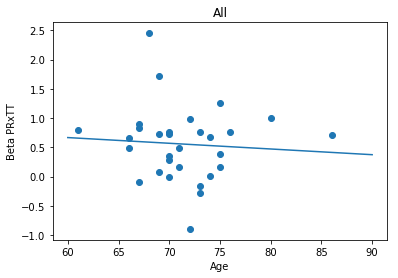

Intercept: 1.3611, Coef: -0.0119
14


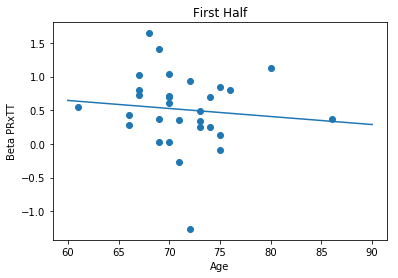

Intercept: 0.3832, Coef: 0.0028
10


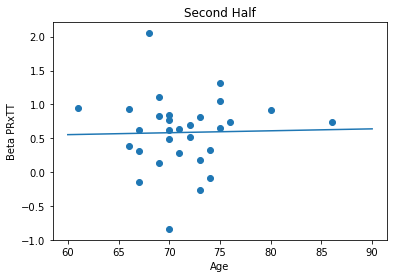

In [5]:
def get_betas(files, start=None, end=None):
    betas_mb = []
    betas_mf = []
    p_vals = []

    for idx, file in enumerate(files):
        file = file[start:end] # Section of files to analyze

        choice1 = file['choice1'] == 1
        choice2 = ~choice1
        state2 = file['state'] == 2
        state3 = ~state2

        state = (choice1 & state2) | (choice2 & state3)

        x1 = state[:-1].values[:, None] # Transition type of previous trial
        x2 = file['won'][:-1].values[:, None] # Reward of previous trial
        x3 = x1 * x2 # Interaction term between previous transition type and reward
        y = file['choice1'][1:].values == file['choice1'][:-1].values # Stay dependent variable

        x = np.concatenate([x1, x2, x3], axis=1)

        lr = LogisticRegression()
        lr.fit(x, y)
        
        _, pv = chi2(x, y)
        
        betas_mb.append(lr.coef_[0, 2]) # Store coefficient of interaction term
        betas_mf.append(lr.coef_[0, 1]) # Store coefficient of reward term
        p_vals.append(pv) # Store p-values for all terms for participant
        
    return betas_mb, betas_mf,  p_vals

betas_mb_all, betas_mf_all, pv_all = get_betas(files)
betas_mb_half1, betas_mf_half1, pv_half1 = get_betas(files, end=100)
betas_mb_half2, betas_mf_half2, pv_half2 = get_betas(files, start=100)

betas = [betas_mb_all, betas_mb_half1, betas_mb_half2]
p_vals = [pv_all, pv_half1, pv_half2]
titles = ['All', 'First Half', 'Second Half']

for i in range(len(betas)):
    lr2 = LinearRegression()
    lr2.fit(age[:, None], betas[i])

    print('Intercept: %.4f, Coef: %.4f' % (lr2.intercept_, lr2.coef_[0]))
    
    pv = np.array(p_vals[i])
    print(sum(pv[:, 2] <= 0.05)) # Print number of participants who's p-value of interaction term are significant

    x_test = np.linspace(60, 90, 300)[:, None]

    loss = (x_test * lr2.coef_ + lr2.intercept_).ravel()

    fig, ax = plt.subplots()

    ax.scatter(age, betas[i])
    ax.plot(x_test, loss)
    ax.set_xlabel('Age')
    ax.set_ylabel('Beta PRxTT')
    ax.set_title(titles[i])
    
    plt.show()

In [6]:
values = [[a, b, c] for a, b, c in zip(age, betas_mb_all, betas_mf_all)]
betas_file = pd.DataFrame(values, index=participant_id, columns=['Age', 'MB_Betas', 'MF_Betas'])
betas_file.to_excel('Participant_Betas.xlsx')

/Users/Nandhini/anaconda/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '0.9.8' or newer of 'xlsxwriter' (version '0.9.6' currently installed).
  warnings.warn(msg, UserWarning)
